# Welcome to Lung Cancer Center of Excellence Workshop 2023!

**This is data description and code snippets made for R users, if you prefer Python, please click [here]()**

## Table of content: <a class="anchor" id="TOC"></a>
* [General information](#General-information)
* [How to download the data](#How-to_download-the-data)
* [Required software and packages](#Required-software-and-packages)
* [I am not able to install required software/packages on my computer, what should I do?](#I-am-not-able-to-install)

Sections containing data description:
* [Clinical data](#Clinical)
    * [Reading data into R](#Clinical-Reading)
    * [Column description](#Clinical-Columns)
    * [Overview plots](#Clinical-plots)
* [Pathology data](#pathology)
    * [Reading data into R](#Pathology-Reading)
    * [Column description](#Pathology-Columns)
    * [Overview plots](#Pathology-plots)
* [Somatic mutation data (per tumor)](#Somatic-mutation-data)
    * [Reading data into R](#Somatic-mutation-Reading)
    * [Column description](#Somatic-mutation-Columns)
    * [Overview plots](#Somatic-mutation-plots)
* [Somatic mutation data (per region)](#Somatic-mutation-region-data)
    * [Reading data into R](#Somatic-mutation-region-Reading)
    * [Column description](#Somatic-mutation-region-Columns)
    * [How to extract mutation coordinates](#Somatic-mutation-region-Coordinates)
    * [Overview plots](#Somatic-mutation-region-plots)
* [Somatic copy number alterations (SCNA)](#Somatic-cna)
    * [Reading data into R](#CNA-Reading)
    * [Column description](#CNA-Columns)
* [Counts for mutational signatures](#Signatures-counts)
    * [Reading data into R](#Signatures-counts-Reading)
    * [Column description](#Signatures-counts-Columns)
* [Weights for mutational signatures](#Signatures-weights)
    * [Reading data into R](#Signatures-weights-Reading)
    * [Column description](#Signatures-weights-Columns)

## General information <a class="anchor" id="General-information"></a>
The workshop is based on data generated by the TRACERx (Tracking Cancer Evolution through Therapy (Rx) project. It is a large-scale research project aimed at understanding how cancer evolves and spreads over time. The project involves collecting multiple samples of tumours and analysing them in detail to identify genetic changes that occur as the cancer progresses.

Overall, **1,644 tumour regions** were sampled at surgery or during follow-up from the first **421 patients** with non-small cell lung cancer (NSCLC). The samples were subjected to whole exome sequencing (WES) and RNA-seq and thoroughly analysed. In total, **432 genomically distinct tumours** were found. The results obtained from this analysis serve as the foundation for generating hypotheses during this workshop.

The available data include:
1. patient pathology and clinical data
2. somatic mutations (per tumor and per region)
3. somatic copy number alterations
4. expression data

While rudimentary plots summarising the data are available below, we highly encourage you to have a brief look through the [collection of TRACERx papers](https://www.nature.com/collections/haffgaicaf). In particular, somatic point and copy number alterations are discussed [here](https://www.nature.com/articles/s41586-023-05783-5) and expression changes are examined [here](https://www.nature.com/articles/s41586-023-05706-4).

--------------------------------------------------------------------------------
## How to download the data <a class="anchor" id="How-to_download-the-data"></a>

[Scroll up](#TOC)

Please head to [zenodo](https://zenodo.org/record/7822002) and press download:

![zenodo](https://github.com/McGranahanLab/LCCE_workshop_2023/blob/master/support_illustrations/zenodo.png)

The archive `figurecode.zip` will be downloaded, please unzip it. It will produce the folder `figurecode`. While the folder contains a multitude of files, we believe a handful of them can go a long way in terms of hypothesis generation:

* 20221109_TRACERx421_all_tumour_df.rds
* [Somatic single point mutations and small indels](#Somatic-mutation-data): 20221123_TRACERx421_mutation_table_region.fst
* Somatic copy number alterations: 20221109_TRACERx421_scna_table.fst

> Coordinates of mutations and CNAs in all listed files are in hg19.

--------------------------------------------------------------------------------
## Required software and packages <a class="anchor" id="Required-software-and-packages"></a>
[Scroll up](#TOC)


In order to load the data into R, perform minimal data wrangling and visualization, we reccomend using `data.table`, `dplyr`, `fst`, `ggplot2` and `ggvenn` packages freely avaible from CRAN. But please do feel free to use any packages you are used to or find helpful!

In [1]:
suppressWarnings(suppressPackageStartupMessages(library(data.table)))
suppressWarnings(suppressPackageStartupMessages(library(dplyr)))
suppressWarnings(suppressPackageStartupMessages(library(fst)))
suppressWarnings(suppressPackageStartupMessages(library(ggplot2)))
suppressWarnings(suppressPackageStartupMessages(library(ggvenn)))

--------------------------------------------------------------------------------

## I am not able to install required software/packages on my computer, what should I do? <a class="anchor" id="I-am-not-able-to-install"></a>

[Scroll up](#TOC)

Insert here how to use google colab

--------------------------------------------------------------------------------
## Clinical data <a class="anchor" id="Clinical"></a>

[Scroll up](#TOC) 

### Reading data into R <a class="anchor" id="Clinical-Reading"></a>
TRACERx cohort consists of 421 patients. Each line in this dataframe corresponds to one of these patients, reporting clinical data.

In [2]:
clinical_df = readRDS('figurecode/data/20221109_TRACERx421_all_patient_df.rds')
# rename columns to match ones in mutation table and cna.
# Please do not skip this step
colnames(clinical_df) = gsub('^cruk_id$', 'patient_id', colnames(clinical_df))
# remove excess columns, please do not skip this step
clinical_df$tumour_id_muttable_cruk = NULL
clinical_df$tumour_id_per_patient = NULL

### Column description <a class="anchor" id="Clinical-Columns"></a>

In [3]:
head(clinical_df)

,patient_id,age,sex,ethnicity,cigs_perday,years_smoking,packyears,smoking_status_merged,is.family.lung,ECOG_PS,⋯,os_time,cens_dfs,dfs_time,cens_dfs_any_event,dfs_time_any_event,cens_lung_event,lung_event_time,Relapse_cat,Relapse_cat_new,tx100
,<chr>,<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<fct>,<lgl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<fct>,<lgl>
1,CRUK0034,68,Female,White- Irish,20.0,35,35.000,Ex-Smoker,TRUE,0,⋯,1849,0,1849,0,1849,0,1849,NA,No rec,TRUE
2,CRUK0150,81,Male,White- British,44.5,49,109.025,Ex-Smoker,FALSE,0,⋯,1362,1,1362,1,1362,0,1362,NA,No rec,FALSE
3,CRUK0159,60,Male,White- British,20.0,38,38.000,Smoker,FALSE,0,⋯,2224,1,2224,1,1935,0,2224,Second primary lung,No rec,FALSE
4,CRUK0090,65,Male,White- British,10.0,35,17.500,Ex-Smoker,FALSE,1,⋯,2365,1,1143,1,1143,1,1143,Intrathoracic,Intrathoracic,TRUE
5,CRUK0045,85,Male,White- British,10.0,25,12.500,Ex-Smoker,FALSE,1,⋯,986,1,917,1,917,1,917,Intrathoracic,Intrathoracic,TRUE
6,CRUK0076,63,Male,White- British,40.0,51,102.000,Smoker,FALSE,1,⋯,1934,0,1934,0,1934,0,1934,NA,No rec,TRUE


* `patient_id` : unique patient identifier
* `age` : age of the patient
* `sex` : sex of the patient
* `ethnicity` : ethnicity of the patient
* `cigs_perday` : number of cigarettes smoked per day. There are non integer values because some patients smoke cigars or pipes, whose amount was converted to the equivalent in cigarette counts. One cigar is assumed to be equivalent to approximately 1.5 cigarettes, and for pipes, one bowl of tobacco is equivalent to 2.5 cigarettes, following the table presented [here](https://gpnotebook.com/simplepage.cfm?ID=x20070115071949295600) for conversions.
* `years_smoking` : number of years the patient has been smoking.
* `packyears` :  number of cigarette packs smoked per year.
* `smoking_status_merged` : smoking status of the patient. Can be one of `Ex-Smoker`,`Smoker`, `Never Smoked`.
* `is.family.lung` : logical indicating whether there is a history of lung cancer in the family.
* `ECOG_PS` : (?)
* `pathologyTNM` : (?)
* `pT_stage_per_lesion` : tumor stage, please see [CRUK TNM staging page](https://www.cancerresearchuk.org/about-cancer/lung-cancer/stages-types-grades/tnm-staging) for the detailed description
* `pN_stage_per_lesion` : lymph node stage, please see [CRUK TNM staging page](https://www.cancerresearchuk.org/about-cancer/lung-cancer/stages-types-grades/tnm-staging) for the detailed description
* `LVI_per_patient` : if patient had lymphovascular invasion (LVI)
* `PL_per_patient` : (?)
* `margin_status_per_patient` : (?)
* `size_pathology_per_patient` : size of the tumor, in mm
* `Surgery_type` : surgery performed on patient. Can be one of `Lobectomy`,`Segmentectomy`, `wedge resection`, `Bilobectomy`, `Pneumonectomy`, `Lobectomy and wedge resection`, `Lingulectomy`.
* `histology_lesion1` : histological subtype of the first lesion, one of `Invasive adenocarcinoma`, `LCNEC`, `Squamous cell carcinoma`,`Pleomorphic carcinoma`, `Adenosquamous carcinoma`, `Carcinosarcoma`, `combined LUAD and LCNEC`, `Large cell carcinoma`, `Collision LUAD and LUSC`.
* `histology_lesion1_merged` : (?)
* `lesion1_sampled` : logical indicator whether first lesion was sampled
* `histology_lesion2` : histological subtype of the second lesion, one of `Minimally invasive adenocarcinoma`, `Lesion1: collision tumour`, `Invasive adenocarcinoma`, `Unknown`, `Squamous cell carcinoma`, `Carcinoid` (when sampled)
* `lesion2_sampled` : logical indicator whether second lesion was sampled
* `histology_multi_full` : (?)
* `histology_multi_full_genomically.confirmed` : (?)
* `LUAD_pred_subtype` :  for LUAD samples, this column contains the tissue architecture growth pattern. Such patterns are inferred from diagnostic H&E slides, and they can be divided in two categories: low-grade (lepidic, mid grade, papillary and acinar) and high-grade (cribriform, micropapillary and solid).
* `adjuvant_treatment_YN` : can either be `No adjuvant` or `Adjuvant` based on whether the patient received adjuvant treatment
* `adjuvant_treatment_given` : which adjuvant treatment was given to the patient. It can be one of `Platinum chemo`, `Radiotherapy` and `Platinum chemo/radiotherapy`. For patients who did not receive adjuvant treatment, this column is NA.
* `num_cycle_na.added` : number of cycles of adjuvant treatment given to the patient. For those who did not receive AT, this column is equal to 0.
* `CHMPlatDgName_cleaned` : name of the chemotherapy platinum agent used in each AT cycle. The drug names for each cycle are separated by ';', e.g., `Cisplatin;Carboplatin`.
* `CHMOthDgName_cleaned` : name of the second chemotherapy drug given in combination with the platinum agent. Drug names in each cycle are separated by ';'.
* `AdjRadStartTime_manual` : time when adjuvant radiotherapy started (when applicable)
* `AdjRadEndTime_manual` : end time point of the adjuvant radiotherapy (when applicable)
* `Recurrence_time_use` : time when recurrence was confirmed
* `newPrim_time_use` : time when a new primary tumour was detected.
* `first_dfs_any_event_rec.or.new.primary` : whether this patient underwent a recurrence event or developed a new primary tumour. There are 41 new primaries, and 5 of them developed a recurrence.
* `first_event_during_followup` : one of `Death`, `new_primary`, `recurrence` and `recurrence (death)`.
* `cens_os` : indicates, if patient was censored for computations of overall survival (OS)
* `os_time` : overall survival time
* `cens_dfs` : indicates, if patient was censored due to death
* `dfs_time` : death time
* `cens_dfs_any_event` : (?)
* `dfs_time_any_event` : (?)
* `cens_lung_event` : (?)
* `lung_event_time` : (?)
* `Relapse_cat` : physical location of relapse tumor, one of `Second primary lung`, `Intrathoracic`, `Intra & Extra`, `Other second primary`, `Extrathoracic`, `Missing data`
* `Relapse_cat_new` : updated physical location of relapse tumor, one of `No rec`, `Intrathoracic`, `Intra & Extra`, `Extrathoracic`, `Unknown Site`
* `tx100` : logical indicator of patient's participation in TRACERx 100 cohort

###  Overview plots  <a class="anchor" id="Clinical-plots"></a>
Let's have a look at patients' distribution across age, sex, ethnicity, number of cigarettes per day and overall pack years

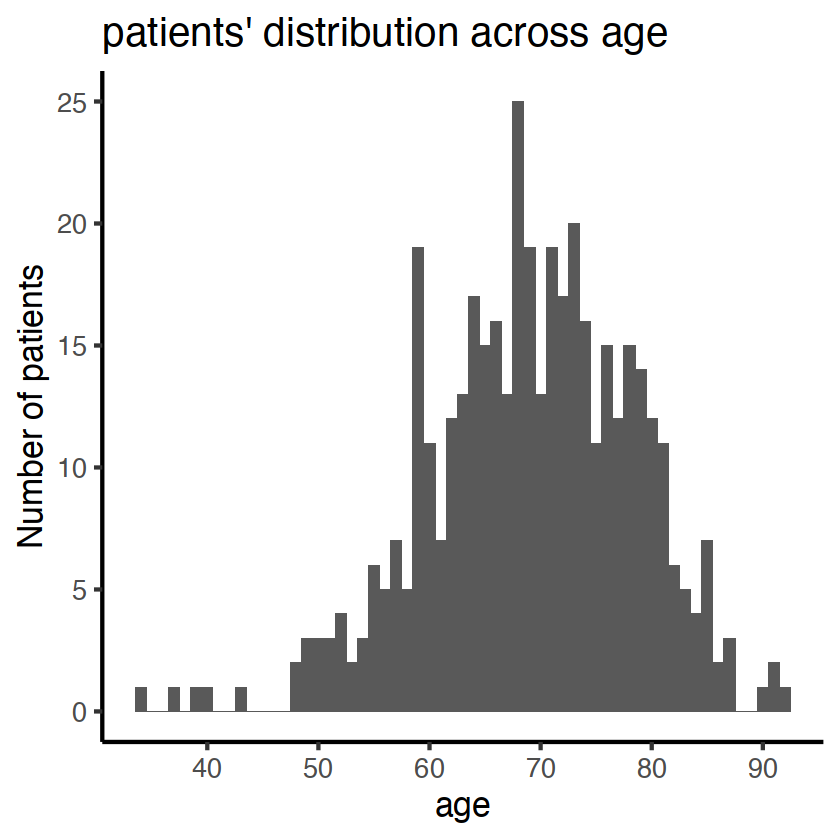

In [4]:
ggplot(data = clinical_df, aes(x = age)) + 
       geom_histogram(binwidth = 1) + 
       ylab('Number of patients') +
       ggtitle("patients' distribution across age") +
       theme_classic(base_size = 20)

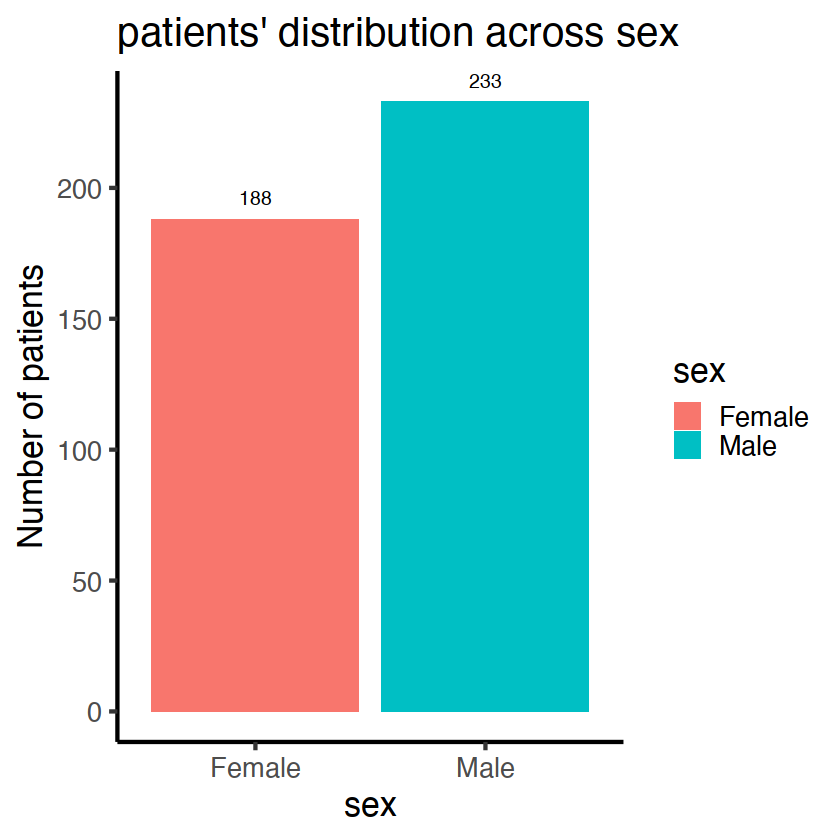

In [5]:
ggplot(data = as.data.table(clinical_df)[,.N, by = sex], 
       aes(x = sex, y = N, fill = sex, label = N)) + 
       geom_text(vjust = -1, size = 4) +
       geom_bar(stat = "identity") + 
       ylab('Number of patients') +
       ggtitle("patients' distribution across sex") +
       theme_classic(base_size = 20)

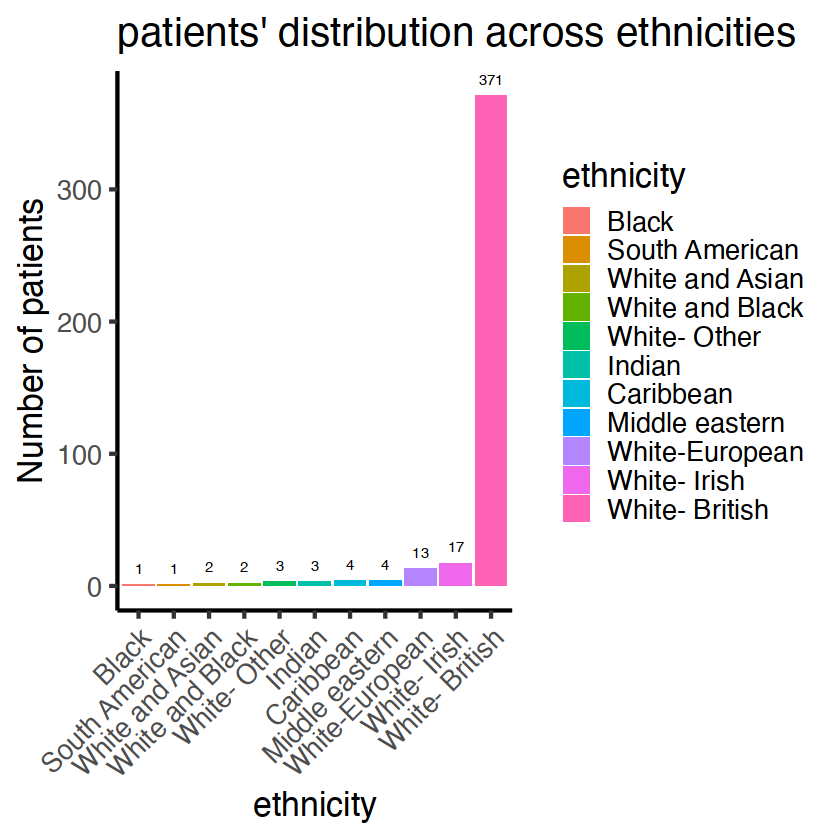

In [6]:
patient_by_ethnicity = as.data.table(clinical_df)
patient_by_ethnicity = patient_by_ethnicity[,(length(unique(patient_id))),
                                            by = ethnicity]
colnames(patient_by_ethnicity)[2] = 'n'
patient_by_ethnicity = patient_by_ethnicity[order(patient_by_ethnicity$n)]
patient_by_ethnicity$ethnicity = factor(patient_by_ethnicity$ethnicity,
                                       patient_by_ethnicity$ethnicity)

ggplot(data = patient_by_ethnicity, 
       aes(x = ethnicity, y = n, 
           fill = ethnicity, label = n)) + 
       geom_bar(stat = "identity") + 
       geom_text(vjust = -1, size = 3) +
       ylab('Number of patients') +
       ggtitle("patients' distribution across ethnicities") +
       theme_classic(base_size = 20) + 
       theme(axis.text.x = element_text(angle = 45, 
                                        hjust = 1))

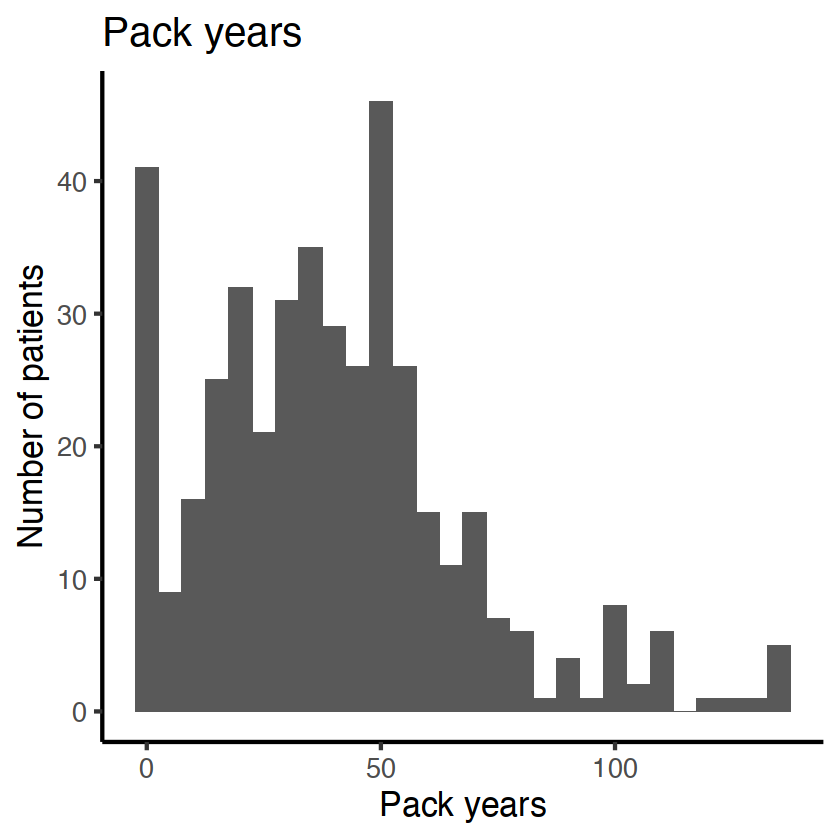

In [7]:
ggplot(data = clinical_df, aes(x = packyears)) + 
       geom_histogram(binwidth = 5) + 
       xlab('Pack years') +  ylab('Number of patients') +
       ggtitle("Pack years") +
       theme_classic(base_size = 20)

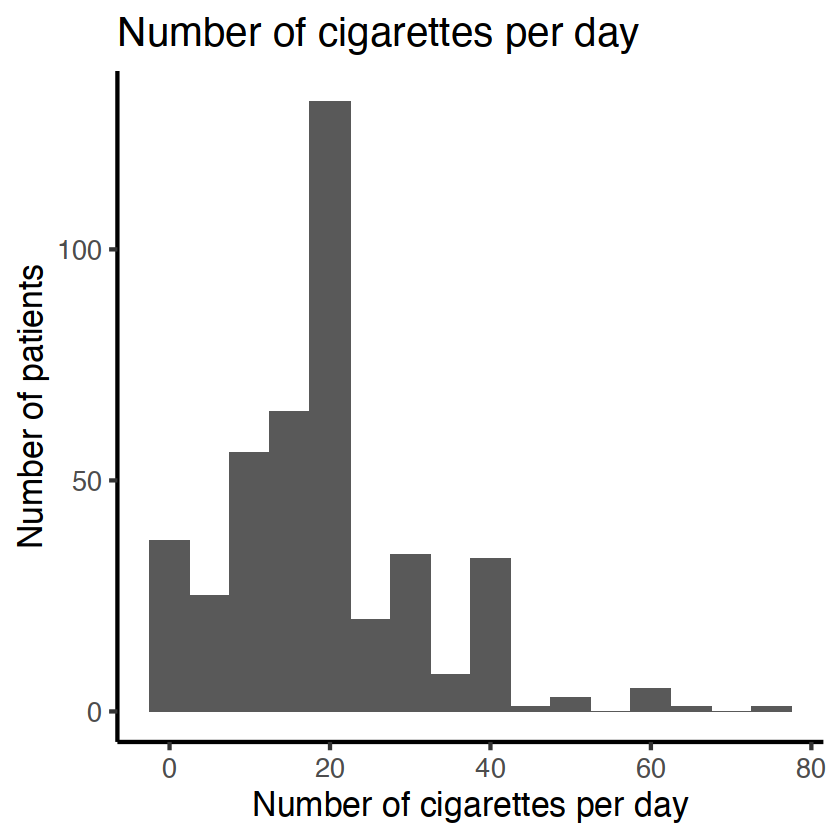

In [8]:
ggplot(data = clinical_df, aes(x = cigs_perday)) + 
       geom_histogram(binwidth = 5) + 
       xlab('Number of cigarettes per day') + 
       ylab('Number of patients') +
       ggtitle("Number of cigarettes per day") +
       theme_classic(base_size = 20)

--------------------------------------------------------------------------------
## Pathology data <a class="anchor" id="pathology"></a>
[Scroll up](#TOC)

TRACERx cohort consists of 421 patients, harbouring 432 genomically independent tumours. Each line in this data frame corresponds to one of these tumours, reporting clinical data and histological features.

### Reading data into R <a class="anchor" id="Pathology-Reading"></a>

In [9]:
tumor_df = readRDS('figurecode/data/20221109_TRACERx421_all_tumour_df.rds')
# rename columns to match ones in mutation table and cna
# please do not skip this step
colnames(tumor_df) = gsub('tumour_id_muttable_cruk', 'tumour_id',
                          colnames(tumor_df))
colnames(tumor_df) = gsub('cruk_id', 'patient_id', colnames(tumor_df))

### Column description <a class="anchor" id="Pathology-Columns"></a>

In [10]:
head(tumor_df)

tumour_id,patient_id,clinical_sex,age,ethnicity,Histology_per_tumour_id_muttable,histology_3,LUAD_pred_subtype_with.IMA_per_tumour,site_per_lesion,pT_stage_per_lesion,pN_stage_per_lesion,size_pathology_per_lesion,vascular_invasion_per_lesion,pleural_invasion_per_lesion,smoking_status_merged,cigs_perday,years_smoking,pack_years,is.family.lung,pathologyTNM
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<fct>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<fct>,<dbl>,<int>,<dbl>,<lgl>,<chr>
CRUK0034,CRUK0034,Female,68,White- Irish,Invasive adenocarcinoma,LUAD,acinar,Right Upper Lobe,2a,0,40,Yes,No,Ex-Smoker,20.0,35,35.000,TRUE,IB
CRUK0150,CRUK0150,Male,81,White- British,LCNEC,Other,NA,Left Upper Lobe,3,0,75,Yes,No,Ex-Smoker,44.5,49,109.025,FALSE,IIB
CRUK0159,CRUK0159,Male,60,White- British,Invasive adenocarcinoma,LUAD,acinar,Right Upper Lobe,2a,0,36,Yes,Yes,Smoker,20.0,38,38.000,FALSE,IB
CRUK0090,CRUK0090,Male,65,White- British,Squamous cell carcinoma,LUSC,NA,Right Upper Lobe,2a,1,35,Yes,Yes,Ex-Smoker,10.0,35,17.500,FALSE,IIA
CRUK0045,CRUK0045,Male,85,White- British,Invasive adenocarcinoma,LUAD,papillary,Left Lower Lobe,2a,0,48,Yes,Yes,Ex-Smoker,10.0,25,12.500,FALSE,IB
CRUK0076,CRUK0076,Male,63,White- British,Squamous cell carcinoma,LUSC,NA,Right Lower Lobe,2a,0,32,No,No,Smoker,40.0,51,102.000,FALSE,IB


The columns in the dataframe are the following:
* `patient_id` : unique patient identifier
* `tumour_id` : unique tumor identifier
* `clinical_sex`: patient sex
* `age` : patient age
* `ethnicity` : patient ethnicity. It is one of: `White- Irish`, `White- British`, `Caribbean`, `Black`, `White and Asian`, `White-European`, `White- Other`, `South American`, `Indian`, `Middle eastern`, `White and Black`)
* `Histology_per_tumour_id_muttable` : full name of the tumor sample histological subtype. It's one of: `Invasive adenocarcinoma`, `LCNEC`, `Squamous cell carcinoma`, `Pleomorphic Adenosquamous carcinoma`, `Carcinosarcoma`, `combined LUAD and LCNEC`, `Large cell carcinoma`, `Collision LUAD and LUSC`.
* `histology_3` : for samples that are either `Invasive adenocarcinoma` or `Squamous cell carcinoma` this column is equal to LUAD and LUSC respectively. For all other histologies, this column contains `Other`.
* `LUAD_pred_subtype_with.IMA_per_tumour` : For LUAD samples, this column contains the tissue architecture growth pattern. Such patterns are inferred from diagnostic H&E slides, and they can be divided in two categories: low-grade (lepidic, mid grade, papillary and acinar) and high-grade (cribriform, micropapillary and solid).
* `site_per_lesion` : location of the tumor. It is one of `Right Upper Lobe`, `Left Upper Lobe`, `Left Lower Lobe`, `Right Lower Lobe`, `Right Middle Lobe`, `Left Upper lobe`
* `pT_stage_per_lesion` : tumor stage, please see [CRUK TNM staging page](https://www.cancerresearchuk.org/about-cancer/lung-cancer/stages-types-grades/tnm-staging) for the detailed description
* `pN_stage_per_lesion` : lymph node stage, please see [CRUK TNM staging page](https://www.cancerresearchuk.org/about-cancer/lung-cancer/stages-types-grades/tnm-staging) for the detailed description
* `size_pathology_per_lesion` : pathological tumor size. (?) how is it calculated? It ranges between 7 and 140
* `vascular_invasion_per_lesion` : logical indicating the presence of lymphovascular invasion.
* `pleural_invasion_per_lesion` : logical indicating the presence of visceral pleural invasion.
* `smoking_status_merged` : smoking status of the patient. Can be `Ex-Smoker`, `Smoker` and `Never Smoked`
* `cigs_perday` : number of cigarettes smoked per day. There are non integer values because some patients smoke cigars or pipes, whose amount was converted to the equivalent in cigarette counts. One cigar is assumed to be equivalent to approximately 1.5 cigarettes, and for pipes, one bowl of tobacco is equivalent to 2.5 cigarettes, following the table presented [here](http://www.smoking2.nes.scot.nhs.uk/module4/working-out-cigarette-equivalents.html) for conversions.
* `years_smoking` : duration for smoking in terms of years.
* `pack_years` : number of cigarette packs smoked per year.
* `is.family.lung` : (?) I don't know what this stands for. Probably is logical indicating whether there is a history of lung cancer in the family.
* `pathologyTNM` : pathological Tumor, Node and Metastasis (TNM) stage (? check I defined it right)

###  Overview plots  <a class="anchor" id="Pathology-plots"></a>
Let's have a look at patients' distribution across tumor subtypes

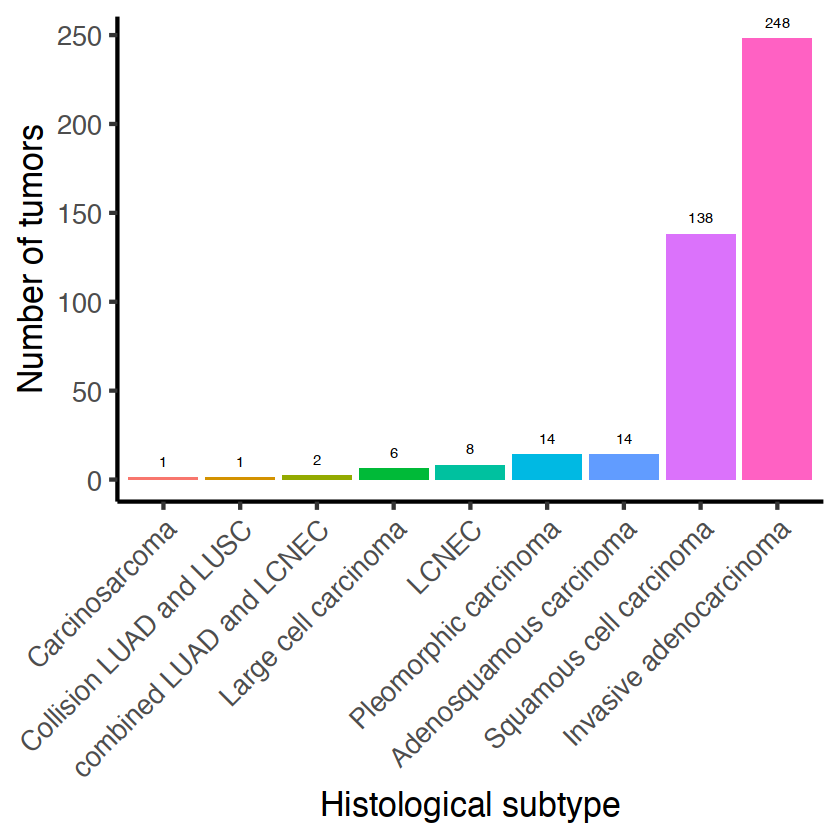

In [11]:
patient_by_subtype = as.data.table(tumor_df)
patient_by_subtype = patient_by_subtype[,(length(unique(tumour_id))),
                                        by = Histology_per_tumour_id_muttable]
colnames(patient_by_subtype) = c('subtype', 'n')
patient_by_subtype = patient_by_subtype[order(patient_by_subtype$n)]
patient_by_subtype$subtype = factor(patient_by_subtype$subtype,
                                    patient_by_subtype$subtype)

ggplot(data = patient_by_subtype, 
       aes(x = subtype, y = n, fill = subtype, label = n)) +
       geom_bar(stat = "identity") + 
       geom_text(vjust = -1, size = 3) +
       xlab('Histological subtype') + ylab('Number of tumors') +
       theme_classic(base_size = 20) + 
       theme(axis.text.x = element_text(angle = 45, 
                                        hjust = 1), 
             legend.position = 'none') 

--------------------------------------------------------------------------------
## Somatic mutation data <a class="anchor" id="Somatic-mutation-data"></a>

[Scroll up](#TOC)

The table  

### Reading data into R <a class="anchor" id="Somatic-mutation-Reading"></a>
The code below shows how to load mutational data in the memory of your computer.


In [75]:
mut_table = read_fst('figurecode/data/20221109_TRACERx421_mutation_table.fst')

# simplify mutation_id, please do not skip this step
muts_to_simplify <- grepl(';', mut_table$mutation_id)
mut_table[muts_to_simplify, ]$mutation_id = sapply(mut_table[muts_to_simplify, ]$mutation_id,
                                                   function(x) sub(':', paste0('_', 
                                                                               gsub('.*;', '', x),
                                                                               ':'), x))
mut_table[muts_to_simplify, ]$mutation_id = gsub(';.*', '',
                                                 mut_table[muts_to_simplify, ]$mutation_id)

# modify exonic.func column for clarity, please do not skip this step
mut_table[grep('UNKNOWN', mut_table$exonic.func), ]$exonic.func <- 'unknown'
                                                   
# re-order columns for clarity, please do no skip this step
mut_table <- mut_table[, c('patient_id', 'tumour_id', 'mutation_id', 
                           'chr', 'start', 'stop', 'ref', 'var',
                           'Hugo_Symbol', 'func', 'exonic.func', 
                           'NucleotideChange', 'AAChange', 
                           'GL_VAF', 'GL_nAlt', 'GL_depth', 
                           'ITHState', 'PyCloneClonal_SC', 
                           'PyCloneCluster_SC', 'cleanCluster_SC',
                           'combTiming_SC', 'DriverMut')]

### Column description <a class="anchor" id="Somatic-mutation-Columns"></a>

In [76]:
head(mut_table)

,patient_id,tumour_id,mutation_id,chr,start,stop,ref,var,Hugo_Symbol,func,⋯,AAChange,GL_VAF,GL_nAlt,GL_depth,ITHState,PyCloneClonal_SC,PyCloneCluster_SC,cleanCluster_SC,combTiming_SC,DriverMut
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<lgl>,<chr>,<lgl>
1,CRUK0005,CRUK0005,CRUK0005:19:34291428:G,chr19,34291428,34291428,G,T,KCTD15,intronic,⋯,NA,0,0,187,1,S,3,TRUE,subclonal,FALSE
2,CRUK0005,CRUK0005,CRUK0005:19:9084770:C,chr19,9084770,9084770,C,A,MUC16,exonic,⋯,p.V2349L,0.39,2,510,1,C,2,TRUE,early,FALSE
3,CRUK0005,CRUK0005,CRUK0005:1:2160418:G,chr1,2160418,2160418,G,T,SKI,exonic,⋯,p.P71P,0,0,114,1,C,2,TRUE,early,FALSE
4,CRUK0005,CRUK0005,CRUK0005:19:40095981:G,chr19,40095981,40095981,G,T,LGALS13,exonic,⋯,p.G86C,0,0,659,1,C,2,TRUE,early,FALSE
5,CRUK0005,CRUK0005,CRUK0005:19:41313703:C,chr19,41313703,41313703,C,G,RAB4B-EGLN2,ncRNA_intronic,⋯,NA,0,0,894,3,S,5,TRUE,subclonal,FALSE
6,CRUK0005,CRUK0005,CRUK0005:20:31387110:T,chr20,31387110,31387110,T,A,DNMT3B,exonic,⋯,p.S483T,0,0,461,1,C,2,TRUE,early,FALSE


* `patient_id` : unique patient identifier
* `tumour_id` : unique tumor identifier
> Please note that one patient can have 2 distinct genomic tumours. For example:

In [77]:
unique(mut_table[mut_table$patient_id == 'CRUK0223', ]$tumour_id)

[1] "CRUK0223_Tumour1" "CRUK0223_Tumour2"

* `mutation_id` : a unique identifier for detected somatic mutation. An identifier has the following format: tumour_id:chromosome:position:**reference** base pair.
* `chr` : chromosome where mutation is located
* `start` : start position of a mutation
* `stop` : end position of a mutation
> `start` and `stop` are matching for all mutations, even for deletions and insertions
* `ref` : reference nucleotide
* `var` : alternative nucleotide
* `Hugo_Symbol` : official gene symbol to which mutation belongs. In case mutation is located in the intergenic space( `fun` column is equal to `intergenic`, the name of the closest gene is given).
* `func` : location of a mutation in respect to a gene it was assigned to. One of:`exonic`, `splicing`, `exonic;splicing`, `UTR3`, `UTR5`, `UTR5;UTR3`, `intronic`, `upstream`, `downstream`,  `upstream;downstream`, `ncRNA_exonic`, `ncRNA_splicing`, `ncRNA_UTR5`, `ncRNA_UTR3`, `ncRNA_intronic` and `intergenic`.
* `exonic.func` : if a mutation is located in an exon, this column will indicate how it disrupts the protein. One of: `frameshift insertion`, `frameshift substitution`, `immediate-stopgain`, `nonframeshift insertion`, `nonframeshift substitution`, `nonsynonymous`, `nonsynonymous SNV`, `stopgain SNV`, `stoploss SNV`, `synonymous`, `synonymous SNV`, `unknown` or `NA`. `synonymous` and `nonsynonymous` indicates that mutation is a multi-nucleotide variants (i.e. CC -> AG), yet it does not result into frameshift or amino acid change.
* `NucleotideChange` : string indicating nucleotide change in the coordinates of CDS. String format is presented in the following notation: c.`reference nucleotide``position in CDS``alternative nucleotide`.
* `AAChange` : string indicating amino acid change in the coordinates of protein. String format is presented in the following notation: p.`reference amino acid``position in protein``alternative amino acid`.
* `GL_VAF` : variant allele frequency (VAF) of a mutation in germline sample
* `GL_nAlt` : number of sequencing reads displaying alternative allele in germline sample
* `GL_depth` : total depth (number of sequencing reads) covering mutation in germline sample
* `ITHState` : intratumor heterogeneity state. One of `1`, `2` or `3`, where
* `PyCloneClonal_SC` : clonality status of a mutation: clonal (`C`) or subclonal(`S`)
* `PyCloneCluster_SC` : cluster id from pyclone to which mutation belongs
* `cleanCluster_SC` : cluster id from pyclone to which mutation belongs, inconsistent clusters were removed
* `combTiming_SC`  : timing then mutation has occurred. One of `subclonal`, `early` (mutation occurs early in tumor development), `late` (mutation occurs late in tumor development), `Unknown` or `NA`
* `DriverMut` : indicates, if mutation is a known driver mutation. Can be `FALSE` or `TRUE`

###  Overview plots  <a class="anchor" id="Somatic-plots"></a>

Let's have a look at the distribution of number of mutations per tumor (also known as mutation burden):

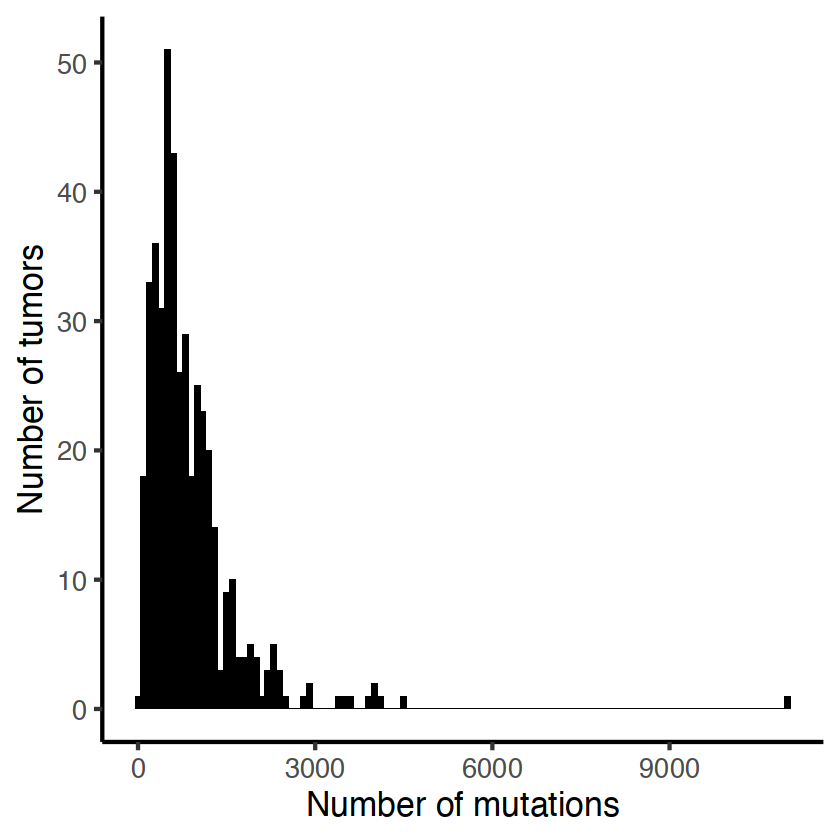

In [78]:
n_muts_per_tumor = as.data.table(mut_table)
n_muts_per_tumor = n_muts_per_tumor[,.(length(unique(mutation_id))),
                                    by = tumour_id]
setnames(n_muts_per_tumor, 'V1', 'n_muts')

ggplot(n_muts_per_tumor, aes(x = n_muts)) + 
       geom_histogram(binwidth = 100, fill = 'black') + 
       xlab('Number of mutations') + 
       ylab('Number of tumors') + 
       theme_classic(base_size = 20)

Let's examine top 20 non-synonymously mutated genes:

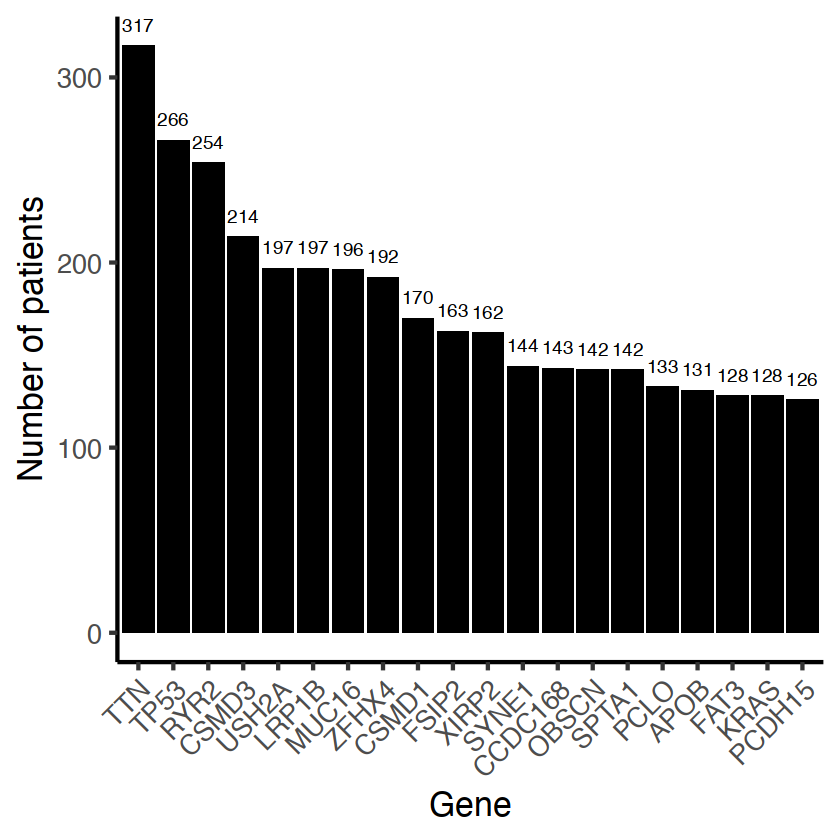

In [93]:
# select non-synonymously mutated genes
n_pats_per_gene = mut_table[mut_table$func %in% c('exonic', 'exonic;splicing'), ]
n_pats_per_gene = n_pats_per_gene[!n_muts_per_gene$exonic.func %in% 
                                   c('synonymous', 'synonymous SNV', 'unknown'), ] 
n_pats_per_gene = n_pats_per_gene[!is.na(n_muts_per_gene$exonic.func), ]

# compute number of patients in which each gene is mutated
n_pats_per_gene = as.data.table(n_pats_per_gene)
n_pats_per_gene = n_pats_per_gene[,.(length(unique(patient_id))), 
                                  by = Hugo_Symbol]
setnames(n_pats_per_gene, 'V1', 'N_patients')

# select top 20
n_pats_per_gene = n_pats_per_gene[order(-N_patients)]
n_pats_per_gene = n_pats_per_gene[1:20]
n_pats_per_gene[, Hugo_Symbol := factor(Hugo_Symbol,
                                        levels = Hugo_Symbol)]

# plot
ggplot(n_pats_per_gene,
       aes(x = Hugo_Symbol, y = N_patients, label = N_patients)) + 
       geom_bar(stat = 'identity', fill = 'black') + 
       geom_text(vjust = -1) +
       xlab('Gene') + ylab('Number of patients') + 
       theme_classic(base_size = 20) + 
       theme(axis.text.x = element_text(angle = 45, hjust = 1))

--------------------------------------------------------------------------------
## Somatic mutation data (per region) <a class="anchor" id="Somatic-mutation-region-data"></a>

[Scroll up](#TOC)

The table loaded above in the [Somatic mutation data](#Somatic-mutation-data) section describes mutations found in every tumor.

### Reading data into R <a class="anchor" id="Somatic-mutation-region-Reading"></a>
The code below shows how to load mutational data in the memory of your computer and to simplify some columns for your convinience. 
> **Please do use the snippet below to read your data in as we performed some modifications in order to streamline your future analysis**

In [94]:
# read table into memory
mut_table_region = read_fst('figurecode/data/20221123_TRACERx421_mutation_table_region.fst')

# simplify RegionID, please do not skip this step
mut_table_region$is_lymphnode = grepl('LN', mut_table_region$RegionID)
mut_table_region$RegionID = gsub('.*[.]R|.*LN', '', mut_table_region$RegionID)
mut_table_region$RegionID = gsub('01', '1', mut_table_region$RegionID)
lymph_ids = mut_table_region$is_lymphnode == T
mut_table_region$RegionID[lymph_ids] = paste0('LN', mut_table_region$RegionID[lymph_ids])
tumor_ids = mut_table_region$is_lymphnode == F
mut_table_region$RegionID[tumor_ids] = paste0('R', mut_table_region$RegionID[tumor_ids])
mut_table_region$RegionID = apply(mut_table_region, 1, 
                                  function(x) paste0(x['tumour_id'], ':', 
                                                     x['RegionID']))
rm(tumor_ids, lymph_ids)

                           
# simplify mutation_id, please do not skip this step
muts_to_simplify <- grepl(';', mut_table_region$mutation_id)
mut_table_region[muts_to_simplify, ]$mutation_id = sapply(mut_table_region[muts_to_simplify, ]$mutation_id,
                                                          function(x) sub(':', 
                                                                          paste0('_', 
                                                                                 gsub('.*;', '', x),
                                                                                 ':'), x))
mut_table_region[muts_to_simplify, ]$mutation_id = gsub(';.*', '',
                                                        mut_table_region[muts_to_simplify, ]$mutation_id)

# simplify MajorCPN_SC and MinorCPN_SC, please do not skip this step
mut_table_region$r_id = gsub('.*:', '', mut_table_region$RegionID)
mut_table_region$r_id = paste0('.*', mut_table_region$r_id, ':')
mut_table_region$MajorCPN_SC = apply(mut_table_region, 1, 
                                     function(x) gsub(x['r_id'], '', x['MajorCPN_SC']))
mut_table_region$MajorCPN_SC = gsub(';.*', '', mut_table_region$MajorCPN_SC)
mut_table_region$MajorCPN_SC = suppressWarnings(as.integer(mut_table_region$MajorCPN_SC))
mut_table_region$MinorCPN_SC = apply(mut_table_region, 1, 
                                     function(x) gsub(x['r_id'], '', x['MinorCPN_SC']))
mut_table_region$MinorCPN_SC = gsub(';.*', '', mut_table_region$MinorCPN_SC)
mut_table_region$MinorCPN_SC = suppressWarnings(as.integer(mut_table_region$MinorCPN_SC))                                                 
                                                    
# re-order columns for clarity
mut_table_region = mut_table_region[, c('tumour_id', 'RegionID', 'is_lymphnode', 'mutation_id', 
                                        'var_count', 'depth', 'Is.present.region', 
                                        'CCF_pyclone_SC', 'CCF_phylo_SC', 'mut_cpn_SC', 
                                        'MajorCPN_SC', 'MinorCPN_SC', 'PyCloneCluster_SC',
                                        'PyCloneClonal_SC', 'cleanCluster_SC')]

In case your computer can't handle such big data frame, you can download the pre-processed version [here]().

### Column description <a class="anchor" id="Somatic-mutation-region-Columns"></a>

In [95]:
head(mut_table_region)

,tumour_id,RegionID,is_lymphnode,mutation_id,var_count,depth,Is.present.region,CCF_pyclone_SC,CCF_phylo_SC,mut_cpn_SC,MajorCPN_SC,MinorCPN_SC,PyCloneCluster_SC,PyCloneClonal_SC,cleanCluster_SC
,<chr>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<chr>,<lgl>
1,CRUK0005,CRUK0005:R1,FALSE,CRUK0005:19:34291428:G,5,159,TRUE,0.54,0.54,0.54,4,2,3,S,TRUE
2,CRUK0005,CRUK0005:R1,FALSE,CRUK0005:19:9084770:C,149,498,TRUE,1.16,1.16,4.57,4,0,2,C,TRUE
3,CRUK0005,CRUK0005:R1,FALSE,CRUK0005:1:2160418:G,27,171,TRUE,0.96,0.96,2.37,2,1,2,C,TRUE
4,CRUK0005,CRUK0005:R1,FALSE,CRUK0005:19:40095981:G,47,507,TRUE,1.21,1.21,1.25,2,0,2,C,TRUE
5,CRUK0005,CRUK0005:R1,FALSE,CRUK0005:19:41313703:C,0,616,FALSE,0.00,0.00,0.00,2,0,5,S,TRUE
6,CRUK0005,CRUK0005:R1,FALSE,CRUK0005:20:31387110:T,68,389,TRUE,0.92,0.92,2.76,3,1,2,C,TRUE


* `tumour_id` : unique tumor identifier
* `RegionID` : a unique identifier for a region inside the tumor. As it is a multiregional data, one tumor can have multiple `RegionID` linked to it. An identifier has the following format: tumour_id:region name. For example, CRUK0005:R1 is an identifier for the region 1 extracted from tumor CRUK0005 during the surgery. If region name starts with **"R"** it means that it was extracted from the actual tumor, and if it starts with **"LN"** the extraction was performed from the lymph node.
* `is_lymphnode` : boolean, indicating if extraction was performed from the actual tumor mass (FALSE) or from a lymph node (TRUE).
* `mutation_id` : a unique identifier for detected somatic mutation. An identifier has the following format: tumour_id:chromosome:position:**reference** base pair.
* `var_count` : number of reads covering that genomic position with the alternative base (mutated base pair) detected at the position.
* `depth` : total depth of sequencing (number of reads) at this position.
* `Is.present.region` : boolean indicator (TRUE/FALSE) of mutation's presence in this region of a tumor.
* `CCF_pyclone_SC` : cancer cell fraction (CCF) of a mutation derived from pyclone. CCF is a proportion of cancer cells that contain this mutation in the region, where 100 means that all cancer cells from the extracted region contain that mutation.
* `CCF_phylo_SC` : cancer cell fraction (CCF) of a mutation derived from a phylogenetic tree.
* `mut_cpn_SC ` : mutation copy number
* `MajorCPN_SC` : copy number of the major allele
* `MinorCPN_SC` : copy number of the minor allele
* `PyCloneCluster_SC` : cluster id from pyclone to which mutation belongs
* `PyCloneClonal_SC ` : clonality status of a mutation: clonal (C) or subclonal(S)
* `cleanCluster_SC` : cluster id from pyclone to which mutation belongs, inconsistent clusters were removed

### How to extract mutation coordinates <a class="anchor" id="Somatic-mutation-region-Coordinates"></a>
It may be useful for some of your analysis to have a separate data frame with the coordinates of all detected somatic mutations. The snippet below provides an example of how the coordinates can be derived from mutation ids.

In [96]:
mutation_coords = strsplit(mut_table_region$mutation_id, ":")
mutation_coords = as.data.frame(do.call(rbind, mutation_coords))
colnames(mutation_coords) = c('tumour_id', 'chr', 'pos', 'REF')
mutation_coords$pos = as.numeric(mutation_coords$pos)
head(mutation_coords)

,tumour_id,chr,pos,REF
,<chr>,<chr>,<dbl>,<chr>
1,CRUK0005,19,34291428,G
2,CRUK0005,19,9084770,C
3,CRUK0005,1,2160418,G
4,CRUK0005,19,40095981,G
5,CRUK0005,19,41313703,C
6,CRUK0005,20,31387110,T


###  Overview plots  <a class="anchor" id="Somatic-mutation-region-plots"></a>

Let's have a quick look at the distribution of number of regions per tumor:

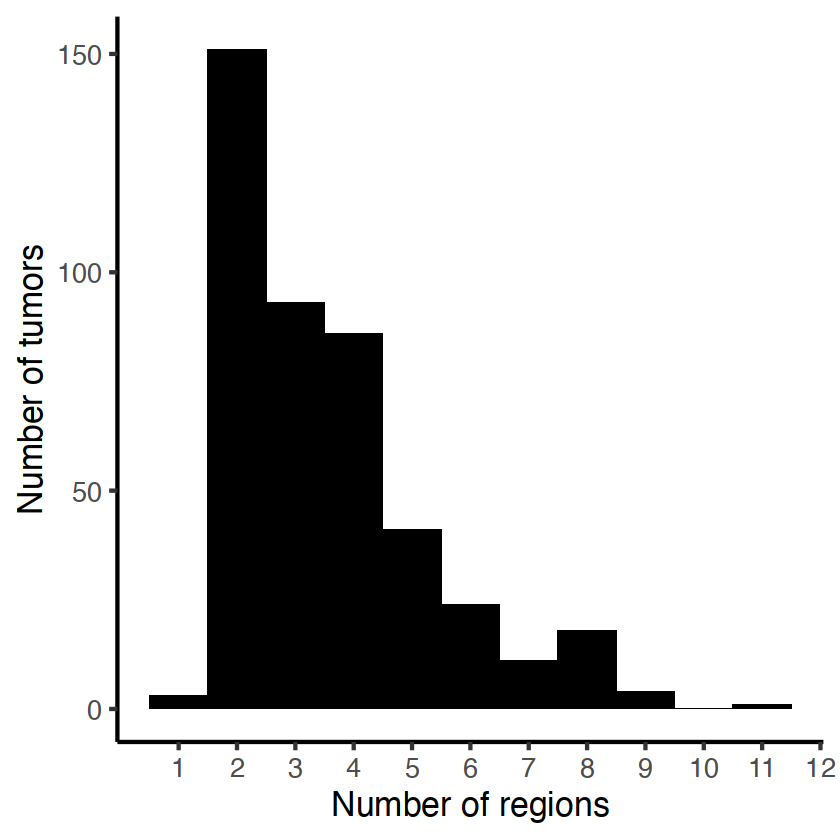

In [101]:
n_regions_per_tumor = as.data.table(mut_table_region)
n_regions_per_tumor = n_regions_per_tumor[,.(length(unique(RegionID))),
                                          by = tumour_id]
setnames(n_regions_per_tumor, 'V1', 'n_regions')

ggplot(n_regions_per_tumor, aes(x = n_regions)) + 
       geom_histogram(binwidth = 1, fill = 'black') + 
       xlab('Number of regions') + 
       ylab('Number of tumors') + 
       scale_x_continuous(breaks = seq(1, 12)) +
       theme_classic(base_size = 20)

Let's find and display overlaps of mutations between regions of `CRUK0005` tumor:

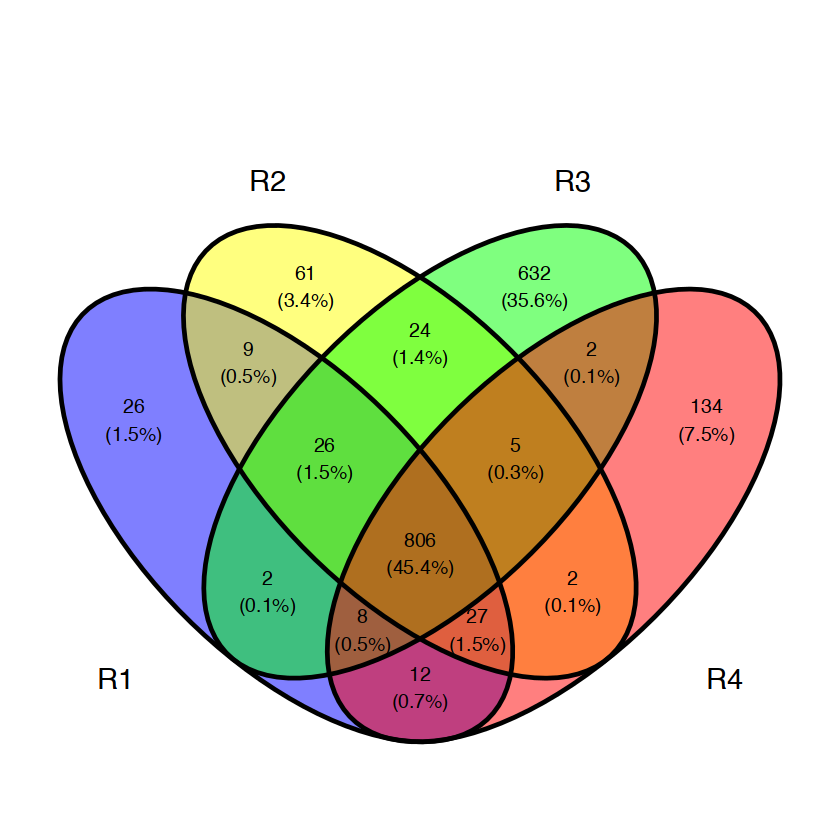

In [127]:
cruk0005_mutations = mut_table_region[mut_table_region$tumour_id == 'CRUK0005', ]
cruk0005_mutations = cruk0005_mutations[cruk0005_mutations$Is.present.region == T, ]
cruk0005_mutations = cruk0005_mutations[, c('RegionID', 'mutation_id')]
regions <- unique(cruk0005_mutations$RegionID)
cruk0005_mutations = lapply(regions,
                            function(x) cruk0005_mutations[cruk0005_mutations$RegionID == x, ]$mutation_id)
names(cruk0005_mutations) <- gsub('.*:', '', regions)
ggvenn(cruk0005_mutations)           

--------------------------------------------------------------------------------

## Somatic copy number alterations (SCNA) <a class="anchor" id="Somatic-cna"></a>

[Scroll up](#TOC)


### Reading data into R <a class="anchor" id="CNA-Reading"></a>
Out of all 1644 tumor regions, there were only 401 tumors for which it was possible to reconstruct phylogenetic trees (only tumors where the purity was sufficient to determine copy number states in at least two regions were retained), for a total of 1428 regions.

This table contains the information about SCNA detected in each tumor sample corresponding to a specific region, inferred from *WES* data. 

In [ ]:
cna_table = read_fst('figurecode/data/20221109_TRACERx421_scna_table.fst')
# rename column sample to RegionID
colnames(cna_table) = gsub('^sample$', 'RegionID', colnames(cna_table))
# bring RegionID format to the one used in mutation table
# Please do not skip this step
cna_table$RegionID = gsub('_.*-', ':', cna_table$RegionID)
cna_table$RegionID = gsub('_SU_LN', ':LN', cna_table$RegionID)
cna_table$RegionID = gsub('LN01', 'LN1', cna_table$RegionID)
special_id = grepl('_', cna_table$tumour_id)
cna_table[special_id, ]$RegionID = gsub('.*:', ':', 
                                        cna_table[special_id, ]$RegionID)

In [ ]:
head(cna_table)

### Column description <a class="anchor" id="CNA-Columns"></a>
The columns are the following:
* `patient_id` : unique patient identifier
* `tumour_id` : unique tumor identifier
> Please note that one patient can have 2 distinct genomic tumours. For example:

In [ ]:
unique(cna_table[cna_table$patient_id == 'CRUK0223', ]$tumour_id)

* `RegionID` : a unique identifier for a region inside the tumor. As it is a multiregional data, one tumor can have multiple `RegionID` linked to it. An identifier has the following format: tumour_id:region name. For example, CRUK0005:R1 is an identifier for the region 1 extracted from tumor CRUK0005 during the surgery. If region name starts with **"R"** it means that it was extracted from the actual tumor, and if it starts with **"LN"** the extraction was performed from the lymph node.
* `chr` - `startpos` - `endpos`: coordinates of the copy number segment: chromosome - start position - end position
* `n.het` : number of heterozygous SNPs called on the segment.
* `cnTotal` : segment total copy number (ASCAT)
* `nMajor` : copy number of the major allele (ASCAT)
* `nMinor` : copy number of the minor allele (ASCAT)
* `Ploidy` : ploidy value of the sample (ASCAT) 
* `ACF` : Aberrant Cell Fraction (fraction of tumor cells in the sample) (ASCAT)
* `nAraw` : raw Allele specific copy number for the A-allele (ASCAT)
* `nBraw` : raw Allele specific copy number for the B-allele (ASCAT)
* `cpn_event_vs_ploidy` : copy number status with respect to the sample ploidy. It is a string whose value can be one of `c('neutral', 'gain', 'amp', 'loss', 'deep_loss')` E.g., if ploidy is 3 and cnTotal is 3, `cpn_event_vs_ploidy` will be `'neutral'`. If ploidy is 3 and cnTotal is 4, then `cpn_event_vs_ploidy` will be `'gain'`.
* `MSAI` : Mirrored Subclonal Allelic Imbalance. Logical indicating whether the corresponding allele specific copy number event corresponds to a mirrored subclonal allelic imbalance.
* `samp_used_to_phase` : ID of the sample whose allelic imbalance data was used to phase SNPs and estimate haplotype specific copy number profiles.

--------------------------------------------------------------------------------

## Counts for mutational signatures <a class="anchor" id="Signatures-counts"></a>

[Scroll up](#TOC)

Somatic mutations observed in tumours are mainly caused by background mutational processes active in the tumour. The processes can be both of endogenous, i.e. DNA replication errors, or exogenous nature, i.e. exposure to carcinogens, such as tobacco smoke or asbestos. Each such mutational process causes a unique combination of mutations in specific trinucleotide contexts called mutational signatures. In the TRACERx study [deconstructSigs](https://github.com/raerose01/deconstructSigs) was used in order to identify each known mutational signatures' contribution to the somatic mutation profile of a tumor and/or region. All 432 tumors and 1553 out of 1644 tumor regions were subjected to this analysis. 

### Reading data into R <a class="anchor" id="Signatures-counts-Reading"></a>

In [ ]:
signature_counts = readRDS('figurecode/data/20221110_TRACERx421_mutationSignature_counts.rds')

# bring RegionID format to the one used in mutation table
# Please do not skip this step
c_perRegion <- signature_counts[['signature_counts_perRegion']]
c_perRegion <- as.data.table(c_perRegion)

c_perRegion[, tumour_id := gsub(":.*", "", RegionID)]
special_id = !c_perRegion$tumour_id %in% signature_counts[['signature_counts_perTumour']]$tumour_id
c_perRegion$tumour_id[special_id] = gsub(":.*T", "_Tumour", 
                                         c_perRegion$RegionID[special_id])
c_perRegion$tumour_id[special_id] = gsub(":SU_LN", "_Tumour", 
                                         c_perRegion$tumour_id[special_id])
c_perRegion$tumour_id[special_id] = gsub("[.].*", "", 
                                         c_perRegion$tumour_id[special_id])
c_perRegion[, RegionID := gsub('.*[.]|.*_', '', RegionID)]
c_perRegion[, RegionID := gsub('01', '1', RegionID)]
c_perRegion[grepl('CRUK0223', tumour_id)]$tumour_id = gsub('1$', '1a', 
                                                            c_perRegion[grepl('CRUK0223',
                                                                              tumour_id)]$tumour_id)
c_perRegion[grepl('CRUK0223', tumour_id)]$tumour_id = gsub('2$', '1', 
                                                            c_perRegion[grepl('CRUK0223',
                                                                              tumour_id)]$tumour_id)
c_perRegion[grepl('CRUK0223', tumour_id)]$tumour_id = gsub('1a$', '2', 
                                                            c_perRegion[grepl('CRUK0223',
                                                                              tumour_id)]$tumour_id)
c_perRegion[tumour_id == 'CRUK0721_Tumour1' & 
            RegionID %in% c('R2', 'R3', 'R4')]$tumour_id = 'CRUK0721_Tumour2'
c_perRegion[tumour_id == 'CRUK0620_Tumour2' & 
            RegionID %in% c('R1')]$tumour_id = 'CRUK0620_Tumour1'
c_perRegion[tumour_id == 'CRUK0301_Tumour1' & 
            RegionID %in% c('R3', 'R4')]$tumour_id = 'CRUK0301_Tumour2'
c_perRegion[tumour_id == 'CRUK0704_Tumour1' & 
            RegionID %in% c('R3', 'R4', 'R5')]$tumour_id = 'CRUK0704_Tumour3'
c_perRegion[tumour_id == 'CRUK0555_Tumour1' & 
            RegionID %in% c('R1', 'R2')]$tumour_id = 'CRUK0555_Tumour2'
c_perRegion[, RegionID := apply(c_perRegion, 1,
                                function(x) paste0(x['tumour_id'], ':',
                                                   x['RegionID']))]
c_perRegion[, tumour_id := NULL]
signature_counts[['signature_counts_perRegion']] <- as.data.frame(c_perRegion) 
rm(c_perRegion)
                                
# bring RegionID format to the one used in mutation table
# Please do not skip this step
c_subcl_perRegion <- signature_counts[['signature_counts_subclonalMuts_perRegion']]
c_subcl_perRegion <- as.data.table(c_subcl_perRegion)

c_subcl_perRegion[, tumour_id := gsub(":.*", "", RegionID)]
special_id = !c_subcl_perRegion$tumour_id %in% signature_counts[['signature_counts_perTumour']]$tumour_id
c_subcl_perRegion$tumour_id[special_id] = gsub(":.*T", "_Tumour", 
                                         c_subcl_perRegion$RegionID[special_id])
c_subcl_perRegion$tumour_id[special_id] = gsub(":SU_LN", "_Tumour", 
                                         c_subcl_perRegion$tumour_id[special_id])
c_subcl_perRegion$tumour_id[special_id] = gsub("[.].*", "", 
                                         c_subcl_perRegion$tumour_id[special_id])
c_subcl_perRegion[, RegionID := gsub('.*[.]|.*_', '', RegionID)]
c_subcl_perRegion[, RegionID := gsub('01', '1', RegionID)]
c_subcl_perRegion[grepl('CRUK0223', tumour_id)]$tumour_id = gsub('1$', '1a', 
                                                            c_subcl_perRegion[grepl('CRUK0223',
                                                                              tumour_id)]$tumour_id)
c_subcl_perRegion[grepl('CRUK0223', tumour_id)]$tumour_id = gsub('2$', '1', 
                                                            c_subcl_perRegion[grepl('CRUK0223',
                                                                              tumour_id)]$tumour_id)
c_subcl_perRegion[grepl('CRUK0223', tumour_id)]$tumour_id = gsub('1a$', '2', 
                                                            c_subcl_perRegion[grepl('CRUK0223',
                                                                              tumour_id)]$tumour_id)
c_subcl_perRegion[tumour_id == 'CRUK0721_Tumour1' & 
            RegionID %in% c('R2', 'R3', 'R4')]$tumour_id = 'CRUK0721_Tumour2'
c_subcl_perRegion[tumour_id == 'CRUK0620_Tumour2' & 
            RegionID %in% c('R1')]$tumour_id = 'CRUK0620_Tumour1'
c_subcl_perRegion[tumour_id == 'CRUK0301_Tumour1' & 
            RegionID %in% c('R3', 'R4')]$tumour_id = 'CRUK0301_Tumour2'
c_subcl_perRegion[tumour_id == 'CRUK0704_Tumour1' & 
            RegionID %in% c('R3', 'R4', 'R5')]$tumour_id = 'CRUK0704_Tumour3'
c_subcl_perRegion[tumour_id == 'CRUK0555_Tumour1' & 
            RegionID %in% c('R1', 'R2')]$tumour_id = 'CRUK0555_Tumour2'
c_subcl_perRegion[, RegionID := apply(c_subcl_perRegion, 1,
                                function(x) paste0(x['tumour_id'], ':',
                                                   x['RegionID']))]
c_subcl_perRegion[, tumour_id := NULL]
c_subcl_perRegion <- c_subcl_perRegion[apply(c_subcl_perRegion, 1, 
                                             function(x) sum(!is.na(x)) > 1)]
signature_counts[['signature_counts_subclonalMuts_perRegion']] <- as.data.frame(c_subcl_perRegion) 
rm(c_subcl_perRegion)

Unlike previous files, this Rds contains several tables collated as a list and accessible as following:

In [ ]:
head(signature_counts[['signature_counts_clonalMuts_perTumour']])

### Column description <a class="anchor" id="Signatures-counts-Columns"></a>

There are six tables in the file:

* `signature_counts_perTumour` - contains signatures' counts per `tumor_id`
* `signature_counts_perRegion` - contains signatures' counts per tumor region (`RegionID`)
* `signature_counts_clonalMuts_perTumour` - contains signatures' counts per tumor (`tumor_id`) computed based on clonal mutations only 
* `signature_counts_privateMuts_perTumour` - contains signatures' counts per tumor (`tumor_id`) computed based on mutations specific to this tumour 
* `signature_counts_subclonalMuts_perRegion` - contains signatures' counts per tumor region (`RegionID`) computed based on subclonal mutations only 
* `signature_counts_subclonalMuts_perTumour`  - contains signatures' counts per tumor (`tumor_id`) computed based on subclonal mutations only

All tables have the same structure described above:
* `tumour_id` or `RegionID` - a unique tumor identifier or unique identifier for a region inside the tumor respectively. As it is a multiregional data, one tumor can have multiple `RegionID` linked to it. An identifier has the following format: tumour_id:region name. For example, CRUK0005:R1 is an identifier for the region 1 extracted from tumor CRUK0005 during the surgery. If region name starts with **"R"** it means that it was extracted from the actual tumor, and if it starts with **"LN"** the extraction was performed from the lymph node.
* `SBS1` - number (counts) of the mutations observed in [SBS1 context (clock-like etiology)](https://cancer.sanger.ac.uk/signatures/sbs/sbs1/).
* `SBS2` - number (counts) of the mutations observed in [SBS2 context (APOBEC activity)](https://cancer.sanger.ac.uk/signatures/sbs/sbs2/).
* `SBS4` - number (counts) of the mutations observed in [SBS4 context (smoking)](https://cancer.sanger.ac.uk/signatures/sbs/sbs4/).
* `SBS5` - number (counts) of the mutations observed in [SBS5 context (unknown, smoking)](https://cancer.sanger.ac.uk/signatures/sbs/sbs5/).
* `SBS13` - number (counts) of the mutations observed in [SBS13 context (APOBEC activity)](https://cancer.sanger.ac.uk/signatures/sbs/sbs13/).
* `SBS17b` - number (counts) of the mutations observed in [SBS context (fluorouracil chemotherapy)](https://cancer.sanger.ac.uk/signatures/sbs/sbs17b/).
* `SBS92`	- number (counts) of the mutations observed in [SBS context (smoking)](https://cancer.sanger.ac.uk/signatures/sbs/sbs92/).
* `SBS44` - number (counts) of the mutations observed in [SBS context (defective DNA mismatch repair)](https://cancer.sanger.ac.uk/signatures/sbs/sbs44/).

--------------------------------------------------------------------------------
## Weights for mutational signatures <a class="anchor" id="Signatures-weights"></a>

[Scroll up](#TOC)

The data below show weight of each signature found in the sample. 

### Reading data into R <a class="anchor" id="Signatures-weights-Reading"></a>

In [ ]:
signature_weights = readRDS('figurecode/data/20221110_TRACERx421_mutationSignature_weights.rds')

# bring RegionID format to the one used in mutation table
# Please do not skip this step
w_perRegion <- signature_weights[['signature_weights_perRegion']]
w_perRegion <- as.data.table(w_perRegion)

w_perRegion[, tumour_id := gsub(":.*", "", RegionID)]
special_id = !w_perRegion$tumour_id %in% signature_weights[['signature_weights_perTumour']]$tumour_id
w_perRegion$tumour_id[special_id] = gsub(":.*T", "_Tumour", 
                                         w_perRegion$RegionID[special_id])
w_perRegion$tumour_id[special_id] = gsub(":SU_LN", "_Tumour", 
                                         w_perRegion$tumour_id[special_id])
w_perRegion$tumour_id[special_id] = gsub("[.].*", "", 
                                         w_perRegion$tumour_id[special_id])
w_perRegion[, RegionID := gsub('.*[.]|.*_', '', RegionID)]
w_perRegion[, RegionID := gsub('01', '1', RegionID)]
w_perRegion[grepl('CRUK0223', tumour_id)]$tumour_id = gsub('1$', '1a', 
                                                            w_perRegion[grepl('CRUK0223',
                                                                              tumour_id)]$tumour_id)
w_perRegion[grepl('CRUK0223', tumour_id)]$tumour_id = gsub('2$', '1', 
                                                            w_perRegion[grepl('CRUK0223',
                                                                              tumour_id)]$tumour_id)
w_perRegion[grepl('CRUK0223', tumour_id)]$tumour_id = gsub('1a$', '2', 
                                                            w_perRegion[grepl('CRUK0223',
                                                                              tumour_id)]$tumour_id)
w_perRegion[tumour_id == 'CRUK0721_Tumour1' & 
            RegionID %in% c('R2', 'R3', 'R4')]$tumour_id = 'CRUK0721_Tumour2'
w_perRegion[tumour_id == 'CRUK0620_Tumour2' & 
            RegionID %in% c('R1')]$tumour_id = 'CRUK0620_Tumour1'
w_perRegion[tumour_id == 'CRUK0301_Tumour1' & 
            RegionID %in% c('R3', 'R4')]$tumour_id = 'CRUK0301_Tumour2'
w_perRegion[tumour_id == 'CRUK0704_Tumour1' & 
            RegionID %in% c('R3', 'R4', 'R5')]$tumour_id = 'CRUK0704_Tumour3'
w_perRegion[tumour_id == 'CRUK0555_Tumour1' & 
            RegionID %in% c('R1', 'R2')]$tumour_id = 'CRUK0555_Tumour2'
w_perRegion[, RegionID := apply(w_perRegion, 1,
                                function(x) paste0(x['tumour_id'], ':',
                                                   x['RegionID']))]
w_perRegion[, tumour_id := NULL]
signature_weights[['signature_weights_perRegion']] <- as.data.frame(w_perRegion) 
rm(w_perRegion)
                                
# bring RegionID format to the one used in mutation table
# Please do not skip this step
w_subcl_perRegion <- signature_weights[['signature_weights_subclonalMuts_perRegion']]
w_subcl_perRegion <- as.data.table(w_subcl_perRegion)

w_subcl_perRegion[, tumour_id := gsub(":.*", "", RegionID)]
special_id = !w_subcl_perRegion$tumour_id %in% signature_weights[['signature_weights_perTumour']]$tumour_id
w_subcl_perRegion$tumour_id[special_id] = gsub(":.*T", "_Tumour", 
                                         w_subcl_perRegion$RegionID[special_id])
w_subcl_perRegion$tumour_id[special_id] = gsub(":SU_LN", "_Tumour", 
                                         w_subcl_perRegion$tumour_id[special_id])
w_subcl_perRegion$tumour_id[special_id] = gsub("[.].*", "", 
                                         w_subcl_perRegion$tumour_id[special_id])
w_subcl_perRegion[, RegionID := gsub('.*[.]|.*_', '', RegionID)]
w_subcl_perRegion[, RegionID := gsub('01', '1', RegionID)]
w_subcl_perRegion[grepl('CRUK0223', tumour_id)]$tumour_id = gsub('1$', '1a', 
                                                            w_subcl_perRegion[grepl('CRUK0223',
                                                                              tumour_id)]$tumour_id)
w_subcl_perRegion[grepl('CRUK0223', tumour_id)]$tumour_id = gsub('2$', '1', 
                                                            w_subcl_perRegion[grepl('CRUK0223',
                                                                              tumour_id)]$tumour_id)
w_subcl_perRegion[grepl('CRUK0223', tumour_id)]$tumour_id = gsub('1a$', '2', 
                                                            w_subcl_perRegion[grepl('CRUK0223',
                                                                              tumour_id)]$tumour_id)
w_subcl_perRegion[tumour_id == 'CRUK0721_Tumour1' & 
            RegionID %in% c('R2', 'R3', 'R4')]$tumour_id = 'CRUK0721_Tumour2'
w_subcl_perRegion[tumour_id == 'CRUK0620_Tumour2' & 
            RegionID %in% c('R1')]$tumour_id = 'CRUK0620_Tumour1'
w_subcl_perRegion[tumour_id == 'CRUK0301_Tumour1' & 
            RegionID %in% c('R3', 'R4')]$tumour_id = 'CRUK0301_Tumour2'
w_subcl_perRegion[tumour_id == 'CRUK0704_Tumour1' & 
            RegionID %in% c('R3', 'R4', 'R5')]$tumour_id = 'CRUK0704_Tumour3'
w_subcl_perRegion[tumour_id == 'CRUK0555_Tumour1' & 
            RegionID %in% c('R1', 'R2')]$tumour_id = 'CRUK0555_Tumour2'
w_subcl_perRegion[, RegionID := apply(w_subcl_perRegion, 1,
                                function(x) paste0(x['tumour_id'], ':',
                                                   x['RegionID']))]
w_subcl_perRegion[, tumour_id := NULL]
w_subcl_perRegion <- w_subcl_perRegion[apply(w_subcl_perRegion, 1, 
                                             function(x) sum(!is.na(x)) > 1)]
signature_weights[['signature_weights_subclonalMuts_perRegion']] <- as.data.frame(w_subcl_perRegion) 
rm(w_subcl_perRegion)

### Column description <a class="anchor" id="Signatures-weights-Columns"></a>

There are six tables in the file:

* `signature_weights_perTumour` - contains signatures' weights per `tumor_id`
* `signature_weights_perRegion` - contains signatures' weights per tumor region (`RegionID`)
* `signature_weights_clonalMuts_perTumour` - contains signatures' weights per tumor (`tumor_id`) computed based on clonal mutations only 
* `signature_weights_privateMuts_perTumour` - contains signatures' weights per tumor (`tumor_id`) computed based on mutations specific to this tumour 
* `signature_weights_subclonalMuts_perRegion` - contains signatures' weights per tumor region (`RegionID`) computed based on subclonal mutations only 
* `signature_weights_subclonalMuts_perTumour`  - contains signatures' weights per tumor (`tumor_id`) computed based on subclonal mutations only 


All tables have the same structure described above:
* `tumour_id` or `RegionID` - a unique tumor identifier or unique identifier for a region inside the tumor respectively. As it is a multiregional data, one tumor can have multiple `RegionID` linked to it. An identifier has the following format: tumour_id:region name. For example, CRUK0005:R1 is an identifier for the region 1 extracted from tumor CRUK0005 during the surgery. If region name starts with **"R"** it means that it was extracted from the actual tumor, and if it starts with **"LN"** the extraction was performed from the lymph node.
* `SBS1` - number (counts) of the mutations observed in [SBS1 context (clock-like etiology)](https://cancer.sanger.ac.uk/signatures/sbs/sbs1/).
* `SBS2` - number (counts) of the mutations observed in [SBS2 context (APOBEC activity)](https://cancer.sanger.ac.uk/signatures/sbs/sbs2/).
* `SBS4` - number (counts) of the mutations observed in [SBS4 context (smoking)](https://cancer.sanger.ac.uk/signatures/sbs/sbs4/).
* `SBS5` - number (counts) of the mutations observed in [SBS5 context (unknown, smoking)](https://cancer.sanger.ac.uk/signatures/sbs/sbs5/).
* `SBS13` - number (counts) of the mutations observed in [SBS13 context (APOBEC activity)](https://cancer.sanger.ac.uk/signatures/sbs/sbs13/).
* `SBS17b` - number (counts) of the mutations observed in [SBS context (fluorouracil chemotherapy)](https://cancer.sanger.ac.uk/signatures/sbs/sbs17b/).
* `SBS92`	- number (counts) of the mutations observed in [SBS context (smoking)](https://cancer.sanger.ac.uk/signatures/sbs/sbs92/).
* `SBS44` - number (counts) of the mutations observed in [SBS context (defective DNA mismatch repair)](https://cancer.sanger.ac.uk/signatures/sbs/sbs44/).

## Additional data

In addition to the TRACERx data, during the workshop we also encourage you to explore external data that may be useful for the task assigned. [cBioPortal](https://www.cbioportal.org/) is a resource that can be used to explore and download cancer genomics datasets. It contains data from multiple cancer studies, and provides a user friendly interface to easily gain insights from the selected datasets. Among the data that can be explored there are mutated driver genes, Copy Number Alterations and clinical features. 
We suggest to explore two studies: [MSK-IMPACT](https://www.cbioportal.org/study/summary?id=msk_impact_2017), which is a collection of 10000 clinical cases, and the [MSK-IMPACT-MET](https://www.cbioportal.org/study/summary?id=mixed_impact_subset_2022), which is a pan cancer collection of 69 metastatic cases. 

The interface enables to stratify samples according to driver mutations, cancer type, clinical features, sample coverage, etc., to explore the corresponding data grouped according to the selected feature.

The portal has a collection of exhaustive tutorials, and we suggest to take a thorough look at them to familiarise with the portal and practice how to access and explore the data. The tutorials can be found [here](https://docs.cbioportal.org/user-guide/overview/). We suggest to familiarise with the guide on single study [exploration](https://raw.githubusercontent.com/cBioPortal/cbioportal/master/docs/tutorials/cBioPortal%20Tutorial%201%20Single%20Study%20Exploration.pdf) and [query](https://raw.githubusercontent.com/cBioPortal/cbioportal/master/docs/tutorials/cBioPortal%20Tutorial%202%20Single%20Study%20Query.pdf), which are useful to understand how to include additional analyses for the purpose of this workshop.